In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from reproject import reproject_interp
from astropy import stats
from astropy.io import fits
from astropy.table import join
from glob import glob 
import sys
import os

sys.path.append('./../')
from modules import dendro_dendro, dendro_misc, dendro_props, dendro_mask

In [4]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, join, vstack
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from reproject import reproject_interp

import astropy.units as au
from astropy import stats
from astrodendro import Dendrogram, pp_catalog
from astropy.wcs import WCS
from astropy.table import Column

from astropy.io import fits
import aplpy
from tqdm.auto import tqdm

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import binary_dilation

from astropy.wcs import WCS

In [5]:
# Define names and filenames...

galaxy = 'ic5332'
galaxy_hst = galaxy
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

hstha_file = '%s/data_hstha/%s/hst_contsub/%s_hst_ha_sic.fits' %(root_dir, galaxy_hst, galaxy_hst)
muscat_file = '%s/data_hstha/%s/muse/%s_nebmask.fits' %(root_dir, galaxy_hst, galaxy.upper())
musha_file = '%s/data_hstha/%s/muse/%s-*_MAPS.fits' %(root_dir, galaxy_hst, galaxy.upper())
musha_file = glob(musha_file)[0] #because of resolution in name

cutout_dir = '%s/data_hstha_nebulae_catalogue/%s/cutouts' %(root_dir, galaxy_hst)
dendro_dir = '%s/data_hstha_nebulae_catalogue/%s/dendro' %(root_dir, galaxy_hst)
cutouts_hdus_dir = '%s/data_hstha_nebulae_catalogue/%s/cutouts_hdus' %(root_dir, galaxy_hst)

rerun_all = True
rerun_masking = True

regions_file = '%s/sample.reg' %cutout_dir
regions_pickel_file = '%s/sample.pickel' %cutout_dir
sample_table_file = '%s/data_misc/sample_table/phangs_sample_table_v1p6.fits' %root_dir
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir

print(hstha_file)
print(muscat_file)
print(musha_file)
print(cutout_dir)
print(dendro_dir)
print(cutouts_hdus_dir)
print(regions_file)
print(regions_pickel_file)
print(sample_table_file)
print(muscat_table_file)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/hst_contsub/ic5332_hst_ha_sic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/muse/IC5332_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/muse/IC5332-0.87asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/dendro
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts_hdus
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/sample.reg
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/sample.pickel
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/sample_table/phangs_sample_table_v1p6.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/Nebulae_catalogue_v3/Nebulae_cata

In [6]:
# Loading files...
hstha_hdu = fits.open(hstha_file)[0]
muscat_hdu = fits.open(muscat_file)[0]

hstha_hdu = dendro_misc.convert_to_float32(hstha_hdu)
muscat_hdu = dendro_misc.convert_to_float32(muscat_hdu)

# Update arrays
muscat_hdu.data = np.array(muscat_hdu.data, dtype=float)
muscat_hdu.data[muscat_hdu.data==-1] = np.nan

# Interpolate masks
muscat_data_re, _ = reproject_interp(muscat_hdu, hstha_hdu.header)
muscat_data_mask = ~np.isnan(muscat_data_re)
data_outmask = hstha_hdu.data[~muscat_data_mask]

# Get RMS for whole map... 
std = stats.mad_std(data_outmask, ignore_nan=True)  # Get noise
std = stats.mad_std(data_outmask[data_outmask<20*std], ignore_nan=True)  # Get noise below threshold

In [7]:
import numpy as np
import astropy.units as au
import astropy.stats as stats
from astropy.io import fits
from spectral_cube import SpectralCube
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation, binary_closing
import random

def get_threshmask(data, rms, thresh=0):
    mask = data > (rms * thresh)
    return mask

def get_circmask(radius=5, h=11, w=11,):
    center = int(h/2)
    X, Y = np.ogrid[:h, :w]
    dist = np.sqrt((X - center)**2 + (Y-center)**2)
    mask = dist <= radius
    return mask *1

def get_prunemask(mask, thresh=10):

    mask_out = mask.copy()
    l, j = ndimage.label(mask_out)
    hist = ndimage.measurements.histogram(l, 0, j+1, j+1)
    os = ndimage.find_objects(l)

    for i in range(j):
        if hist[i+1]<thresh:
            mask_out[os[i]] = 0

    return(mask_out)

In [8]:
data_inmask = hstha_hdu.data.copy()
data_inmask[~muscat_data_mask] = np.nan

mask_low = get_threshmask(data_inmask, std, thresh=1)
mask_high = get_threshmask(data_inmask, std, thresh=5)
mask_grow = binary_dilation(mask_high, iterations=-1, mask=mask_low)
structure = get_circmask()
mask_close = binary_closing(mask_grow, iterations=1, structure=structure)
mask_prune = get_prunemask(mask_close)

hdu_mask = fits.PrimaryHDU(mask_prune*1, hstha_hdu.header)
hdu_mask.writeto('%s/%s_threshold_mask.fits'  %(dendro_dir, galaxy), overwrite=True)

In [9]:
# Loading files...
hstha_hdu = fits.open(hstha_file)[0]
muscat_hdu = fits.open(muscat_file)[0]

hstha_hdu = dendro_misc.convert_to_float32(hstha_hdu)
muscat_hdu = dendro_misc.convert_to_float32(muscat_hdu)

# Update arrays
muscat_hdu.data = np.array(muscat_hdu.data, dtype=float)
muscat_hdu.data[muscat_hdu.data==-1] = np.nan

# Interpolate masks
muscat_data_re, _ = reproject_interp(muscat_hdu, hstha_hdu.header)
muscat_data_mask = ~np.isnan(muscat_data_re)
data_outmask = hstha_hdu.data[~muscat_data_mask]

# Get RMS for whole map... 
std = stats.mad_std(data_outmask, ignore_nan=True)  # Get noise
std = stats.mad_std(data_outmask[data_outmask<20*std], ignore_nan=True)  # Get noise below threshold

# Load regions, sample table and HDUs... 
hdus_cutouts = dendro_misc.load_pickle('%s/hdus_all.pickel' %cutout_dir)
regions = dendro_misc.load_pickle(regions_pickel_file)

sample_table = dendro_misc.get_galaxyprops(galaxy, sample_table_file)
muscat_table = dendro_misc.get_museprops(galaxy, muscat_table_file)

# Load cutout hdus with smoothed, masked, and non-masked data...
hdus_file = '%s/hdus_all_withmasked.pickel' %cutout_dir
muscat_regionIDs_file =  '%s/muscat_regionIDs.pickel' %cutout_dir

if os.path.exists(hdus_file) & ~rerun_masking:
    muscat_regionIDs = muscat_table['region_ID']
    hdus = dendro_misc.load_pickle(hdus_file)
else: 
    muscat_regionIDs = muscat_table['region_ID']
    hdus = dendro_dendro.get_maskedhdus(hdus_cutouts, regions, muscat_regionIDs)
    dendro_misc.save_pickle(hdus, hdus_file)

[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/hdus_all.pickel
[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/sample.pickel
[INFO] [get_galaxyprops] Getting sample table properties for ic5332...
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ic5332...
[INFO] [get_maskedhdus] Getting HST maps masked by MUSE catalouge...


Masking regions:   0%|          | 0/816 [00:00<?, ?it/s]

[INFO] [save_pickle] Saved to /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ic5332/cutouts/hdus_all_withmasked.pickel


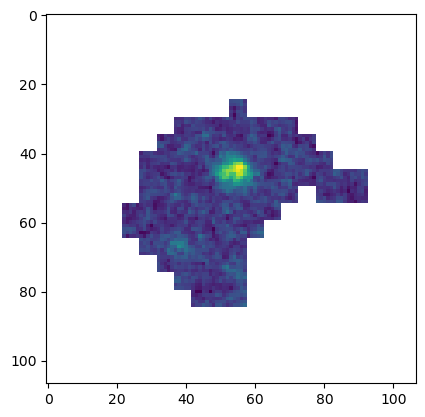

In [13]:
i = 491 

plt.imshow(hdus['hstha_hdu_smooth_masked'][i].data)

In [ ]:
data_inmask = hstha_hdu.data.copy()
data_inmask[~muscat_data_mask] = np.nan

mask_low = get_threshmask(data_inmask, std, thresh=1)
mask_high = get_threshmask(data_inmask, std, thresh=5)
mask_grow = binary_dilation(mask_high, iterations=-1, mask=mask_low)
structure = get_circmask()
mask_close = binary_closing(mask_grow, iterations=1, structure=structure)
mask_prune = get_prunemask(mask_close)

hdu_mask = fits.PrimaryHDU(mask_prune*1, hstha_hdu.header)
hdu_mask.writeto('%s/%s_threshold_mask.fits'  %(dendro_dir, galaxy), overwrite=True)

In [31]:
props_all = []
indexmap_trunk_hdu_all = []
indexmap_trunk_close_hdu_all = []
first_no_found_run = 0

for i in tqdm(range(len(muscat_regionIDs)), desc='Dendrogram', position=0):

    # if i >10: 
    #     continue
    
    muscat_regionID = muscat_regionIDs[i]

    if not all_nan_check(hdus, i): 

        output = get_dedro(hdus['hstha_hdu_smooth_masked'][i],
                            hdus['hstha_hdu_smooth_maskedall'][i], 
                            hdus['hstha_hdu_smooth'][i],
                            sampletable=sampletable,
                            min_npix=min_npix, 
                            min_value_sig=min_value_sig, 
                            min_delta_sig=min_delta_sig, 
                            std=std)

        dendro, props, indexmap_trunk_hdu, indexmap_trunk_close_hdu = output
